In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [ ]:
df =  pd.read_csv('/content/drive/MyDrive/Mltiverse/MLtiVerse (1)/train.csv')

In [ ]:
df

In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
## importaant function that will be used during whole cycle

#to display list of all features that contain missing values
def missValueFeatures(dataset):
  features = [features for features in dataset.columns if dataset[features].isnull().sum()>0]
  return features

#To draw a plot that shows the relationship between missing values and present value with respect to target variable
def missValuePlot(dataset, li, target_variable):
  for feature in li:
    data = dataset.copy()
    print(data[feature].isnull().sum())
    data[feature] = np.where(data[feature].isnull(),1,0)
    data.groupby(feature)[target_variable].mean().plot.bar()
    plt.title(feature)
    plt.show()

#seperating independent and dependent feature
def depIndepFeature(dataset, dep_feature):
  X = dataset.drop(dep_feature, axis=1)
  y = pd.DataFrame(dataset[dep_feature])
  return X,y

#for univariate feature imputation
#Here data is all those rows and columns where you want to apply imputation
from sklearn.impute import SimpleImputer
def simpleImputation(data, estimator):
  from sklearn.impute import SimpleImputer
  imputer = SimpleImputer(missing_values=np.nan, strategy=estimator)
  imputer.fit(data)
  data = imputer.transform(data)
  return data

#for multivariate feature imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def iterativeImputation(data):
  imputer = IterativeImputer(max_iter=10, random_state=0)
  imputer.fit(data)
  data = imputer.transform(data)
  return data

#removing rows containing null values
def nullValuesRemoval(dataset, li):
  df = dataset.dropna(subset = li)
  return df

#list of all numerical features
def numericalFeatures(dataset):
  numerical_features = [features for features in dataset.columns if dataset[features].dtypes != 'O']
  return numerical_features

#list of all discrete numerical features
def discreteNumericalFeatures(dataset, numerical_features):
  discreteNumericalFeatures = [feature for feature in numerical_features if len(dataset[feature].unique())<25 and feature not in ['ID']]
  return discreteNumericalFeatures

#list of all continuous features
def continuousNumericalFeatures(dataset, numerical_features, discrete_numerical_features):
  continuous_numerical_features = [feature for feature in numerical_features if feature not in discrete_numerical_features + ['ID']]
  return continuous_numerical_features
#list of all categorical features
def categoricalFeatures(dataset, numerical_features, temporal_features):
  categorical_features = [features for features in dataset.columns if dataset[features].dtypes == 'O' and features not in numerical_features + temporal_features]
  return categorical_features

#Relationship between discrete numerical features and target variable
def discreteTargetRelation(dataset, discrete_numerical_features, target_variable):
  for feature in discrete_numerical_features:
    data = dataset.copy()
    data.groupby(feature)[target_variable].mean().plot.bar()
    plt.xlabel(feature)
    plt.ylabel(target_variable)
    plt.title(feature)
    plt.show()

#For plotting Pdf curve for continuous numericl feature
def pdf(dataset, continuous_numerical_features):
  for feature in continuous_numerical_features:
    data = dataset.copy()
    sns.distplot(data[feature])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

#Relationship between continuous features and target variable
def continuousTargetRelation(dataset, continuous_numerical_features, target_variable):
  for feature in continuous_numerical_features:
    data = dataset.copy()
    if 0 in data[feature].unique():
      pass
    else:
      data[feature] = np.log(data[feature])
      data[target_variable] = np.log(data[target_variable])
      plt.scatter(data[feature], data[target_variable])
      plt.xlabel(feature)
      plt.ylabel(target_variable)
      plt.title(feature)
      plt.show()

#For plotting outliers
def plotOutliers(dataset, continuous_numerical_features):
  for feature in continuous_numerical_features:
    data = dataset.copy()
    if 0 in data[feature].unique():
      pass
    else:
      data[feature] = np.log(data[feature])
      data.boxplot(column = feature)
      plt.ylabel(feature)
      plt.title(feature)
      plt.show()

# Defining a function to calculate the number of outliers using z-score method
def count_outliers_zscore(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    num_outliers = (z_scores > threshold).sum()
    return num_outliers

#For number of outliers using DBSCAN algo.
from sklearn.cluster import DBSCAN
def find_outliers_dbscan(data, epsilon, min_samples):
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(data)
    labels = dbscan.labels_
    labels_list = list(labels)
    # Count the number of outliers for each feature
    num_outliers = labels_list.count(-1)
    return num_outliers

#For number of outliers using ECOD PyOD algo.
!pip install pyod
from pyod.models.ecod import ECOD
def detect_outliers_ecod(data, threshold=95):
    # Convert the data to a NumPy array
    X = np.array(data)

    # Create an ECOD model and fit it to the data
    model = ECOD()
    model.fit(X)

    # Obtain the outlier scores for each data point
    scores = model.decision_scores_

    # Define the threshold based on the given percentile
    threshold_value = np.percentile(scores, threshold)

    # Detect outliers for each feature
    outliers = []
    for i in range(X.shape[1]):
        feature_scores = scores[:, i]
        feature_outliers = X[np.where(feature_scores > threshold_value)]
        outliers.append(feature_outliers)

    # Return the outliers for each feature
    return outliers


#Log normal transformatioon to remove outliers
def log_normal_transform(dataset):
    transformed_data = dataset.copy()
    non_zero_mask = transformed_data != 0
    transformed_data[non_zero_mask] = np.log(transformed_data[non_zero_mask])
    return transformed_data

#Flooring and capping for removal of outliers
def quantile_floor_cap(dataset, column, lower_quantile=0.05, upper_quantile=0.95):
    lower_bound = dataset[column].quantile(lower_quantile)
    upper_bound = dataset[column].quantile(upper_quantile)
    dataset[column] = dataset[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return dataset

#converting the rare categorical values to rare_var
def rareVarConversion(dataset, target_variable, features):
  for feature in features:
    temp = dataset.groupby(feature)[target_variable].count()/len(dataset)
    temp_df = temp[temp>0.0005].index
    dataset[feature] = np.where(dataset[feature].isin(temp_df),dataset[feature],"Rare_var")
    return dataset

#Remove all outliers from a dataset
from scipy import stats
def remove_outliers(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers_mask = np.any(z_scores > threshold, axis=1)
    cleaned_data = data[~outliers_mask]
    return cleaned_data

#function for building ann model
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
def build_model_using_sequential(hidden_units1, hidden_units2, hidden_units3, learning_rate):
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model

def remove_outlier(df_in, col_name):
  q1 = df_in[col_name].quantile(0.25)
  q3 = df_in[col_name].quantile(0.75)
  iqr = q3-q1 #Interquartile range
  fence_low  = q1-1.5*iqr
  fence_high = q3+1.5*iqr
  df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
  return df_out

In [ ]:
#converting Value and Wage column in Euros
df['Value'] = df['Value'].apply(lambda x: 0 if x == '€ 0.00' or x == '€0' else (float(x[1:-1]) * 1000 if 'K' in x else (float(x[1:-1]) * 1000000 if 'M' in x else x)))
df['Wage'] = df['Wage'].apply(lambda x:  (float(x[1:-1]) * 1000) if 'K' in x else (float(x[1:]) ))


In [ ]:
#converting release
from pandas.core.dtypes.dtypes import dtypes
data = df.copy()
data1 = data["Release Clause"]
data_numeric = []
for value in data1:
    if isinstance(value, str):
        numeric_value = float(value[1:-1]) * 1e6  if value[-1] == 'M' else float(value[1:-1]) * 1e3
        data_numeric.append(numeric_value)
    else:
        data_numeric.append(np.nan)
series = pd.Series(data_numeric)
median = series.median()
df["Release Clause"] = df["Release Clause"].fillna(median)
df["Release Clause"] = df["Release Clause"].apply(lambda x: x if type(x) == float else (float(x[1:-1]) * 1e3) if 'K' else (float(x[1:-1]) * 1e6) if 'M' in x else x)

In [ ]:
#finding total number of days of contract
data = df.copy()
temporal_features = ["Joined" , "Contract Valid Until"]
data['Joined'] = pd.to_datetime(data['Joined'])
data['Contract Valid Until'] = pd.to_datetime(data['Contract Valid Until'])
df['Days_of_contract'] = (data['Contract Valid Until'] - data['Joined']).dt.days
df.drop(['Joined', 'Contract Valid Until'], axis=1, inplace=True)

In [ ]:
df['Weight'] = df['Weight'].apply(lambda x: int(x[0:3]))
df["Preferred Foot"] = df["Preferred Foot"].apply(lambda x : 1 if "Right" in x else 0)
df["Height"] = df["Height"].apply(lambda x : int(int(x[0])*12 + int(x[2:])))

In [ ]:
features_with_missing_values = missValueFeatures(df)
features_with_missing_values

In [ ]:
target_variable = 'Value'
missValuePlot(df, features_with_missing_values, target_variable)

In [ ]:
#list of features containing null values with zero mean
li = ['Club', 'Body Type', 'Real Face', 'Position', 'Jersey Number', 'Volleys', 'Curve', 'Agility', 'Balance', 'Jumping', 'Interceptions', 'Positioning', 'Vision', 'SlidingTackle']
df = nullValuesRemoval(df, li)


In [ ]:
#features with missing values that are not corresponding to zeroes are
features_with_missing_values_reduced0 = missValueFeatures(df)
features_with_missing_values_reduced0

In [ ]:
df.shape

In [ ]:
print(len(df['Name'].unique()))
print(len(df['Photo'].unique()))
print(len(df['Flag'].unique()))
print(len(df['Club Logo'].unique()))

In [ ]:
print(len(df['ID'].unique()))
print(len(df['Nationality'].unique()))
print(len(df['Club'].unique()))

In [ ]:
#from above info we can remove flag, Club logo, photo, id, name
df.drop(['ID', 'Name', 'Photo', 'Flag', 'Club Logo', 'Loaned From', 'Nationality', 'Club', 'Best Position', 'Position'], axis=1, inplace=True)


In [ ]:
numerical_features = numericalFeatures(df)
discrete_numerical_features = discreteNumericalFeatures(df, numerical_features)
continuous_numerical_features = continuousNumericalFeatures(df, numerical_features, discrete_numerical_features)
categorical_features = categoricalFeatures(df, numerical_features, temporal_features)

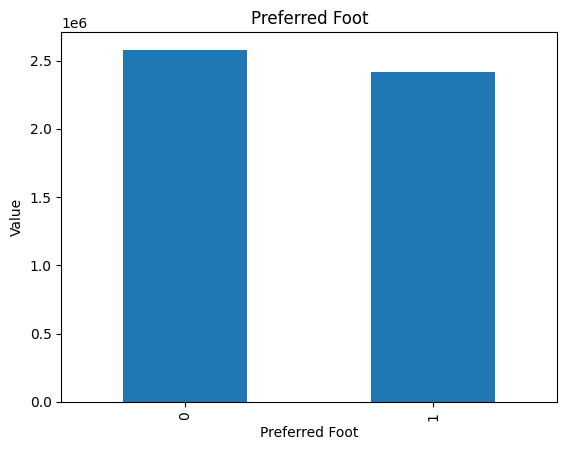

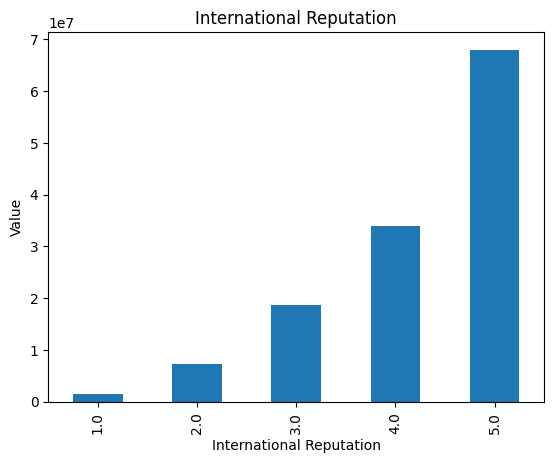

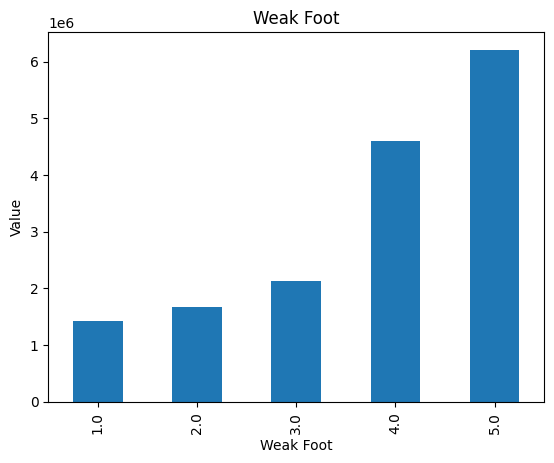

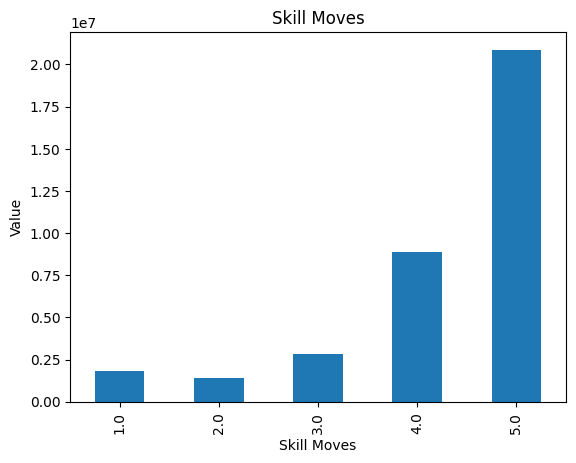

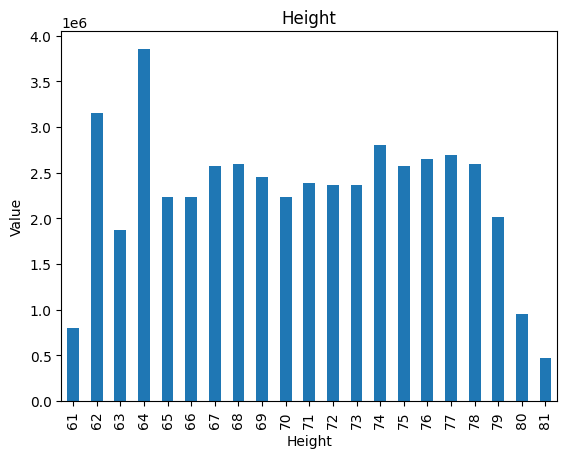

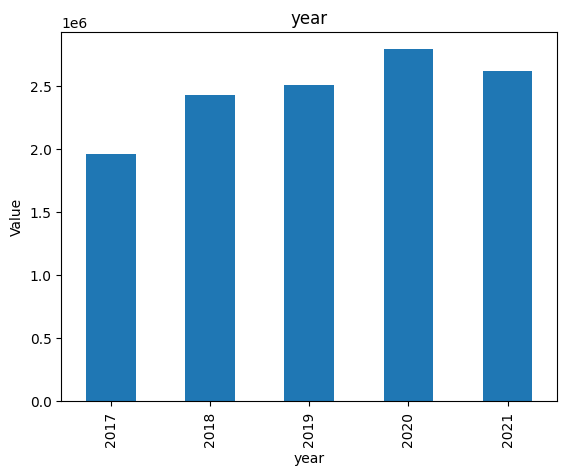

In [ ]:
target_variable = "Value"
discreteTargetRelation(df, discrete_numerical_features, target_variable)

In [ ]:
len(numerical_features)

52

In [ ]:
len(categorical_features)

3

In [ ]:
pdf(df, continuous_numerical_features)

In [ ]:
target_variable = "Value"
continuousTargetRelation(df, continuous_numerical_features, target_variable)

In [ ]:
plotOutliers(df, continuous_numerical_features)

In [ ]:
for column in df[numerical_features].columns:
    num_outliers = count_outliers_zscore(df[column])
    print(f"Number of outliers in {column}: {num_outliers}")

In [ ]:
dep_feature = "Value"
X, y = depIndepFeature(df, dep_feature)

In [ ]:
estimator = "median"
data = df[numerical_features]
univariate_imputed_X = simpleImputation(data, estimator)

In [ ]:
multivariate_imputed_X = iterativeImputation(data)

In [ ]:
univariate_imputed_X = pd.DataFrame(univariate_imputed_X)

In [ ]:
multivariate_imputed_X = pd.DataFrame(multivariate_imputed_X)

In [ ]:
univariate_imputed_X = univariate_imputed_X.rename(columns=dict(zip(univariate_imputed_X.columns, df[numerical_features].columns)))

In [ ]:
categorical_df = df[categorical_features]
univariate_imputed_X.reset_index(drop=True, inplace=True)
categorical_df.reset_index(drop=True, inplace=True)
df_univariate_imputed = pd.concat([univariate_imputed_X, categorical_df], axis = 1)

In [ ]:
multivariate_imputed_X.reset_index(drop=True, inplace=True)
categorical_df.reset_index(drop=True, inplace=True)
df_multivariate_imputed = pd.concat([multivariate_imputed_X, categorical_df], axis=1)

In [ ]:
# for column in multivariate_imputed_X.columns:
#     num_outliers = count_outliers_zscore(df[column])
#     print(f"Number of outliers in {column}: {num_outliers}")

In [ ]:
# features = ['Age', 'Overall',	'Potential',	'Value',	'Wage', 'Weak Foot',	'Skill Moves',	'Jersey Number',	'Height',	'Weight',	'ShortPassing',	'Penalties', 'GKDiving',	'GKHandling',	'GKKicking',	'GKPositioning',	'GKReflexes',	'Best Overall Rating',	'year', 'Days_of_contract']
# df_multivariate_imputed[features] = log_normal_transform(df_multivariate_imputed[features])

In [ ]:
df_univariate_imputed.isnull().sum()

In [ ]:
features = ['Work Rate',	'Body Type',	'Real Face']
for feature in features:
  df.groupby(feature)["Value"].mean().plot.bar()
  plt.show()

In [ ]:
#encoding categorical variables
!pip install category_encoders
import category_encoders as ce
encoder= ce.OrdinalEncoder(cols=['Work Rate'],return_df=True,
                           mapping=[{'col':'Work Rate',
'mapping':{'NA/ NA':0,'Low/ Low':1,'Low/ Medium':2,'Medium/ Medium':3, 'Low/ High':4, 'Medium/ Low':5, 'High/ Low':6, 'Medium/ High':7, 'High/ Medium':8, 'High/ High':9}}])
df_univariate_imputed['Work_Rate_transformed'] = encoder.fit_transform(df_univariate_imputed['Work Rate'])
df_univariate_imputed.drop("Work Rate", axis = 1, inplace = True)

In [ ]:
encoder= ce.OrdinalEncoder(cols=['Real Face'],return_df=True,
                           mapping=[{'col':'Real Face',
'mapping':{'No':0, 'Yes':1}}])
df_univariate_imputed['Real_Face_transformed'] = encoder.fit_transform(df_univariate_imputed['Real Face'])
df_univariate_imputed.drop("Real Face", axis = 1, inplace = True)


In [ ]:
features = ['Body Type']
target_variable = "Value"
df_univariate_imputed = rareVarConversion(df_univariate_imputed, target_variable, features)

In [ ]:
df_univariate_imputed['Body Type'].value_counts()

In [ ]:
df_univariate_imputed.groupby('Body Type')["Value"].mean().plot.bar()

In [ ]:
df_univariate_imputed['Body Type'] = df_univariate_imputed['Body Type'].astype('category')
df_univariate_imputed['Body Type'] = df_univariate_imputed['Body Type'].cat.remove_categories("Rare_var")

In [ ]:
df_univariate_imputed = df_univariate_imputed[df_univariate_imputed['Body Type'] != 'Rare_var']
df_univariate_imputed

In [ ]:
encoder = ce.BinaryEncoder(cols=['Body Type'],return_df=True)
df_univariate_imputed = encoder.fit_transform(df_univariate_imputed)
df_univariate_imputed

In [ ]:
# encoder = ce.BinaryEncoder(cols=['Position'],return_df=True)
# df_multivariate_imputed = encoder.fit_transform(df_multivariate_imputed)
# df_multivariate_imputed

In [ ]:
# encoder = ce.BinaryEncoder(cols=['Best Position'],return_df=True)
# df_multivariate_imputed = encoder.fit_transform(df_multivariate_imputed)
# df_multivariate_imputed

In [ ]:
df_univariate_imputed = df_univariate_imputed.rename(columns=dict(zip(df_univariate_imputed.columns, numerical_features)))
df_univariate_imputed

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Mltiverse/MLtiVerse (1)/test_transformed.csv')


In [ ]:
x = df_univariate_imputed.drop(["Value"], axis=1)
y = pd.DataFrame(df_univariate_imputed["Value"])

In [ ]:
df_multivariate_imputed

In [ ]:
#log normal transformation of variables which contain many outliers
features_to_be_normalised = ['Age', 'Wage', 'Weak Foot', 'Skill Moves', 'Jersey Number', 'Weight', 'GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
x[features_to_be_normalised] = log_normal_transform(x[features_to_be_normalised])
for column in x.columns:
    num_outliers = count_outliers_zscore(x[column])
    print(f"Number of outliers in {column}: {num_outliers}")

In [ ]:
x_train = x[:int(0.8 * len(df_univariate_imputed))]
x_test = x[int(0.8 * len(df_univariate_imputed)):]
y_train = y.iloc[:int(0.8 * len(df_univariate_imputed))]
y_test = y.iloc[int(0.8 * len(df_univariate_imputed)):]

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
feature_sel_model = SelectFromModel(Lasso(alpha = 0.005, random_state = 0))
feature_sel_model.fit(x, y)

In [ ]:
feature_sel_model.get_support()

In [ ]:
selected_feature = x.columns[(feature_sel_model.get_support())]
x = x[selected_feature]

In [ ]:
features = ["Wage","Special","Weight","Release Clause", "DefensiveAwareness", "Days_of_contract"]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train[features] = sc.fit_transform(x_train[features])
x_test[features] = sc.transform(x_test[features])

In [ ]:
features = ["Wage","Special","Weight","Release Clause", "DefensiveAwareness", "Days_of_contract"]
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x[features] = sc.fit_transform(x[features])
test_data[features] = sc.transform(test_data[features])

In [ ]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components = i)
# X_train = pca.fit_transform(x_train)
# X_test = pca.transform(x_test)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 50, random_state = 0)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)


In [ ]:
pd.set_option('display.max_rows', None)
importances = model.feature_importances_
features = x.columns
imp = pd.DataFrame({'Features': features, 'Importance': importances})
imp.sort_values(by='Importance',ascending=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
regressor.fit(x, y)

In [ ]:
test_data = test_data.reindex(columns=x.columns)

In [ ]:
predictions = regressor.predict(test_data)

In [ ]:
predictions

In [ ]:
test_data_photo = pd.read_csv("/content/drive/MyDrive/Mltiverse/MLtiVerse (1)/test_data_photo.csv")

In [ ]:
predictions = pd.DataFrame(predictions)

In [ ]:
# from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(y_test, predictions)
# rmse = np.sqrt(mse)
# print("RMSE:", rmse)

In [ ]:
df_full_result = pd.concat((test_data_photo, predictions), axis = 1)

In [ ]:
df_full_result = df_full_result.rename(columns=dict(zip(df_full_result.columns, ['Photo', 'Value'])))

In [ ]:
df_null_result = pd.read_csv("/content/drive/MyDrive/Mltiverse/MLtiVerse (1)/df_null_result.csv")

In [ ]:
submission_6 = pd.concat((df_full_result, df_null_result), axis = 0)

In [ ]:
submission_6.set_index("Photo", inplace = True)

In [ ]:
submission_6.to_csv("/content/drive/MyDrive/Mltiverse/MLtiVerse (1)/submission_6.csv")